In [1]:
# 自定义绘制KS曲线
def plot_ks(y_test, y_score, positive_flag):
    #y_test, y_score重新设置索引
    y_test.index = np.arange(len(y_test))
    #y_score.index = np.arange(len(y_score))
    #构建数据集
    target_data = pd.DataFrame({'y_test':y_test, 'y_score':y_score})
    target_data.sort_values(by='y_score', ascending = False, inplace = True)
    #自定义分位点
    cuts = np.arange(0.1, 1, 0.1)
    index = len(target_data.y_score)*cuts
    scores = target_data.y_score.iloc[index.astype('int')]
    # 根据不同的Score值，计算Sensitivity和Specificity
    Sensitivity = []
    Specificity = []
    for score in scores:
        # 正例覆盖样本数量与实际正例样本量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        # 负例覆盖样本数量与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
    # 构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity), 
                              'ks':np.array(Sensitivity)-(1-np.array(Specificity))})
    # 寻找Sensitivity和1-Specificity之差的最大值索引
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
    # 添加参考线
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index], 
               ymax = plot_data.y2[max_ks_index], linestyles = '--')
    # 添加文本信息
    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
    # 显示图例
    plt.legend()
    # 显示图形
    plt.show()

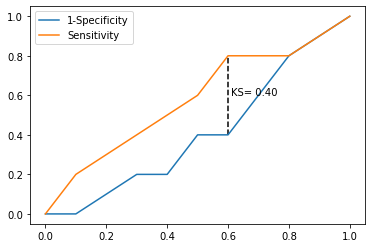

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

virtual_data = pd.read_excel(r'virtual_data.xlsx')
# 应用自定义函数绘制k-s曲线
plot_ks(y_test = virtual_data.Class, y_score = virtual_data.Score,positive_flag = 'P')
plt.show()

In [3]:
# 逻辑回归模型
from sklearn import linear_model
from sklearn import model_selection

sports = pd.read_csv(r'Run or Walk.csv')
predictors = sports.columns[4:]
X = sports.loc[:,predictors]
y = sports.activity
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)
sklearn_logistic = linear_model.LogisticRegression()
sklearn_logistic.fit(X_train, y_train)
display(sklearn_logistic.intercept_, sklearn_logistic.coef_)

array([4.36637441])

array([[ 0.48695898,  6.87517973, -2.44872468, -0.01385936, -0.16085022,
         0.13389695]])

In [4]:
# 模型预测
sklearn_predict = sklearn_logistic.predict(X_test)
pd.Series(sklearn_predict).value_counts()

0    12119
1    10028
dtype: int64

In [5]:
# 模型评价
from sklearn import metrics
#混淆矩阵
cm = metrics.confusion_matrix(y_test, sklearn_predict, labels=[0,1])
display(cm)

Accuracy = metrics.accuracy_score(y_test, sklearn_predict)
Sensitivity = metrics.recall_score(y_test, sklearn_predict)
Specificity = metrics.recall_score(y_test, sklearn_predict, pos_label=0)
print('模型准确率为%.2f%%:' %(Accuracy*100))
print('正例覆盖率为%.2f%%' %(Sensitivity*100))
print('负例覆盖率为%.2f%%' %(Specificity*100))

array([[9969, 1122],
       [2150, 8906]], dtype=int64)

模型准确率为85.23%:
正例覆盖率为80.55%
负例覆盖率为89.88%


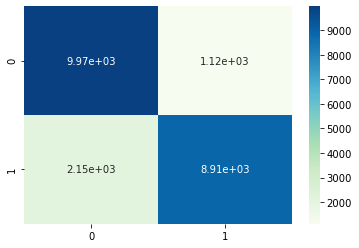

In [6]:
# 混淆矩阵可视化
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='.2e', cmap='GnBu')
plt.show()

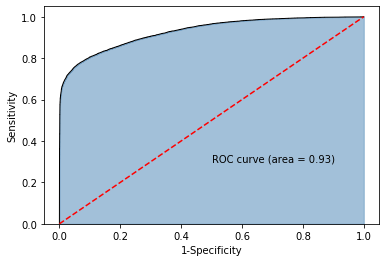

In [7]:
# 绘制ROC曲线
# y得分为模型预测正例的概率
y_score = sklearn_logistic.predict_proba(X_test)[:,1]
# 计算不同阈值下，fpr和tpr的组合值，其中fpr表示1-Specificity，tpr表示Sensitivity
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# AUC的值
roc_auc = metrics.auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

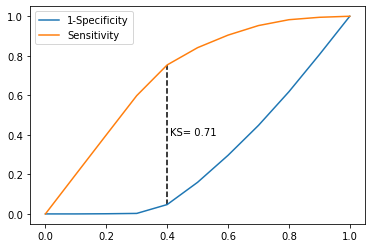

In [8]:
# 调用自定义函数，绘制K-S曲线
plot_ks(y_test = y_test, y_score = y_score, positive_flag = 1)

In [9]:
# -----------------------第一步 建模 ----------------------- #
# 导入第三方模块
import statsmodels.api as sm
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 1234)
# 为训练集和测试集的X矩阵添加常数列1
X_train2 = sm.add_constant(X_train)
X_test2 = sm.add_constant(X_test)
# 拟合Logistic模型
sm_logistic = sm.Logit(y_train, X_train2).fit()
# 返回模型的参数
sm_logistic.params

Optimization terminated successfully.
         Current function value: 0.324875
         Iterations 8


const             4.388537
acceleration_x    0.489617
acceleration_y    6.906590
acceleration_z   -2.459638
gyro_x           -0.014715
gyro_y           -0.161164
gyro_z            0.134655
dtype: float64

In [10]:
# -----------------------第二步 预测构建混淆矩阵 ----------------------- #
# 模型在测试集上的预测
sm_y_probability = sm_logistic.predict(X_test2)
# 根据概率值，将观测进行分类，以0.5作为阈值
sm_pred_y = np.where(sm_y_probability >= 0.5, 1, 0)
# 混淆矩阵
cm = metrics.confusion_matrix(y_test, sm_pred_y, labels = [0,1])
cm

array([[9967, 1124],
       [2149, 8907]], dtype=int64)

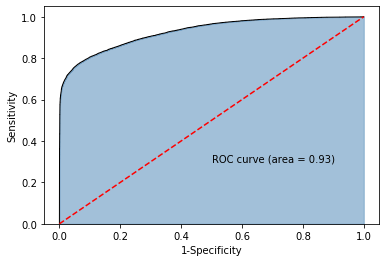

In [11]:
# -----------------------第三步 绘制ROC曲线 ----------------------- #
# 计算真正率和假正率 
fpr,tpr,threshold = metrics.roc_curve(y_test, sm_y_probability)
# 计算auc的值  
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

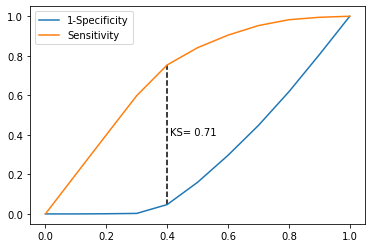

In [12]:
# -----------------------第四步 绘制K-S曲线 ----------------------- #
# 调用自定义函数，绘制K-S曲线
sm_y_probability.index = np.arange(len(sm_y_probability))
plot_ks(y_test = y_test, y_score = sm_y_probability, positive_flag = 1)